In this notebook I will try to recreate the results of Tsonis/Dones et. al. Here are the steps:
1. ~~Filter out data (Tsonis does it, Donges does not)~~
1. ~~Produce climatalogical average for each grid point~~
1. ~~Classify each year as El Nino or not~~
1. ~~Produce time series for each grid point~~
1. ~~Correlate each pair of time series (Tsonis samples 60 random points, Dones does ?)~~
1. ~~Clip correlations and produce network~~
1. ~~View map of area-weighted link number (Tsonis figure 1)~~
1. Network Analsysi

Catalogue of tests:
1. Using temperature data from Jan. 1951- Jan. 2020. Differentiating between Nino/a just like Tsonis. Didn't produce same network stats
1. Trim temperature range to match Tsonis: Jan. 1951- Dec. 2005 (Tsonis only said 1950-2005, so I'm guessing a bit)

In [1]:
from netCDF4 import Dataset
import mpl_toolkits.basemap as bmp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime as dt
import colorcet as cc
import utilities as cnutils
import itertools
from scipy.stats import pearsonr
import networkx as nx
import sys
import time
import graph_tool.all as gt

/home/samserra/anaconda3/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/samserra/anaconda3/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/samserra/anaconda3/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/samserra/anaconda3/lib/python3.7/site-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo'
  warnings.warn(msg, RuntimeWarning)


# Import/FilterData

In [2]:
# Most recent NCAR Reanalysis File (as of 2020-02-29)
reanalysis = Dataset(
    '../Data/NCEP-NCAR Reanalysis (R1)/Monthly Surface Temperatures/air.mon.mean.nc', mode='r')

In [3]:
# Display some useful output
cnutils.ncdump(reanalysis)

NetCDF Global Attributes:
	description: 'Data from NCEP initialized reanalysis (4x/day).  These are the 0.9950 sigma level values'
	platform: 'Model'
	Conventions: 'COARDS'
	NCO: '20121012'
	history: 'Thu May  4 20:11:16 2000: ncrcat -d time,0,623 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc air.mon.mean.nc\nThu May  4 18:11:50 2000: ncrcat -d time,0,622 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc ./surface/air.mon.mean.nc\nMon Jul  5 23:47:18 1999: ncrcat ./air.mon.mean.nc /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc /dm/dmwork/nmc.rean.ingest/combinedMMs/surface/air.mon.mean.nc\n/home/hoop/crdc/cpreanjuke2farm/cpreanjuke2farm Mon Oct 23 21:04:20 1995 from air.sfc.gauss.85.nc\ncreated 95/03/13 by Hoop (netCDF2.3)\nConverted to chunked, deflated non-packed NetCDF4 2014/09'
	title: 'monthly mean air.sig995 from the NCEP Reanalysis'
	References: 'http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.html'
	dataset_title: 'NCEP-NCAR

(['description',
  'platform',
  'Conventions',
  'NCO',
  'history',
  'title',
  'References',
  'dataset_title'],
 ['lat', 'lon', 'time'],
 ['lat', 'lon', 'time', 'air'])

In [4]:
# extract all longitudes, latitudes, and times
lons = reanalysis.variables['lon'][:]
lats = reanalysis.variables['lat'][:]
times = reanalysis.variables['time'][:]

In [5]:
# date format is hours since 1800-01-01, so convert to normal date format
dates_orig = np.array(
    [dt.date(1800, 1, 1) + dt.timedelta(hours=t) for t in times])

## Optional Filtering 

In [6]:
# Tsonis et al only uses data from Nov-Mar to avoid seasonal variability. However, Donges et al does not, claiming it does not affect their results.
# If the bool 'nov_to_march' is 'True',only data from Nov-Mar will be used. Else all data will be used

nov_to_march = True
if nov_to_march:
    # create mask for nov-march date range
    mask = []
    for d in dates_orig:
        # true if d.month is Jan-Mar or Nov-Dec
        mask.append((d.month <= 3) | (d.month >= 11))
    air = reanalysis.variables['air'][mask, :, :]
    dates = dates_orig[mask]
else:
    air = reanalysis.variables['air'][:]

# Produce Anomaly-from-Climatalogical-Average Temps

For every lat/long/month, produce average over all years. Store in array with dimensions (lat, lon)

In [7]:
# look at the month of the first 12 entries of 'dates' to get set of all valid months
valid_months = []
for d in dates[:12]:
    valid_months.append(d.month)
valid_months = set(valid_months)

clim_averages = np.zeros(air.shape)
for mon in valid_months:  # for each month,
    # create month mask
    mask = []
    for d in dates:
        mask.append(d.month == mon)

    # produce climatalogical averages for every lat/lon pair for the current month
    clim_averages[mask, :, :] = np.mean(air[mask, :, :], axis=0)

# produce anomaly values
air_anom = air - clim_averages

# Classify Years as El Nino or Not! 

So, Tsonis seems to split the data into El Nino/La Nina time series and then calculate correlations only between pairs of Nino or Nina series. Donges does not do this. Moreover, Tsonis uses a non-standard (at least, non-standard nowdays) means of determining which years are El Nino or not. IDK what to do. Do I follow Tsonis to the letter or change it up??  

## Four Defs of El Nino!
So, I've thus far encountered (at least) four different definitions of El Nino. 
* Tsonis et al. say an El Nino occurs when the normalized Southern Occillation Index (SOI) exceeds 1 and a La Nina when is is less than -1. 
* NOAA has (at leas) two definitions, both based on the Oceanic Nino Index (ONI), which is the running three-month average of the monthly average Sea Surface Temperature (SST) in the Nino 3.4 region of the Pacific. 
    * The first definition states that when the ONI exceeds 0.5, an El Nino is occuring whereas if it is less than -0.5, a La Nina is occuring. 
    * The second definition states that for there to be declared an El Nino, the ONI must exceed 0.5 *for 5 consecutive months*, and likewise with La Nina. 
* In addition, there is a similar 4th definition based on the Nino 3.4 Index, which is a 5-month running SST anomaly. Here, for an El Nino to be declared, the Nino 3.4 Index must exceed 0.4 for a period of 6 consecutive months, and likewise for a La Nina

## Tsonis's Definition 
Let's just start here and see what happens...I will generate a list of months/years which are El Nino, La Nina, or Normal based on SOI

In [8]:
soi = np.loadtxt("../Data/soi.txt", skiprows=88,
                 max_rows=70, usecols=np.arange(1, 13))
# each column is a month jan-dec, so flatten to get 1-d list of all dates
soi = np.ravel(soi)
# last 10 months are nonsense, and reanalysis only goes to february, so chop last 11 months off
soi = soi[:-11]
# finaly, mask data to match previous filtering
mask = []
for d in dates_orig[3*12:]:
    # true if d.month is Jan-Mar or Nov-Dec
    mask.append((d.month <= 3) | (d.month >= 11))
soi = soi[mask]

In [9]:
# generate mask for El Nino months
elnino_months = soi > 1
# generate mask for La Nina months
lanina_months = soi < -1
# generate mask for normal months
normal_months = (1-(elnino_months+lanina_months)
                 ).astype('bool')  # not(elnino or lanina)

Finaly, the Reanalysis data goes back to 1948, but I only have the SOI from 1951-present. Hence, we need to cut off the first 3 years of SAT data

In [10]:
air_anom_trimed = air_anom[3*len(valid_months):, :, :]
dates_trimed = dates[3*len(valid_months):]

Additionally, trim data back to 2005 (for second test)

In [11]:
# subtract off 14 years of valid months plus Jan 2020
air_anom_trimed = air_anom_trimed[:-(14*len(valid_months)+1)]
dates_trimed = dates_trimed[:-(14*len(valid_months)+1)]
elnino_months = elnino_months[:-(14*len(valid_months)+1)]
lanina_months = lanina_months[:-(14*len(valid_months)+1)]
normal_months = normal_months[:-(14*len(valid_months)+1)]

In [12]:
print("{:^19s} | {:^19s} | {:^18s} | {:^17s} ".format(
    "Num. El Nino Months", "Num. La Nino Months", "Num. Normal Months", "Total Num. Months"))
print("{:^19n}  {:^19n}  {:^18n}  {:^17n}".format(
    sum(elnino_months), sum(lanina_months), sum(normal_months), len(elnino_months)))

Num. El Nino Months | Num. La Nino Months | Num. Normal Months | Total Num. Months 
        54                   36                  185                 275       


Problem: Tsonis has 330 months per grid point. However, from 1950-2005 is 55 years, which means they must be using 6 months per year (330/55=6). However, they say they only use data from Nov-March, which is 5 months. Me no comprehendo.

# Produce Time Series for Each Grid Point

In [13]:
# seperate SAT into El Nino, La Nina, and Normal
air_anom_elnino = air_anom_trimed[elnino_months, :, :]
air_anom_lanina = air_anom_trimed[lanina_months, :, :]
air_anom_normal = air_anom_trimed[normal_months, :, :]
# and the dates
dates_elnino = dates_trimed[elnino_months]
dates_lanina = dates_trimed[lanina_months]
dates_normal = dates_trimed[normal_months]

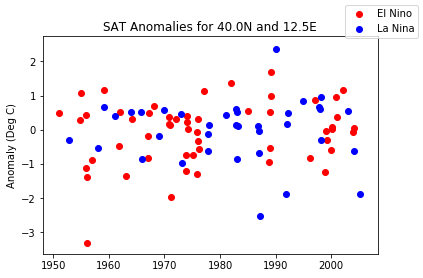

In [14]:
fig, ax = plt.subplots()
fig.set_facecolor('white')
ax.set_title('SAT Anomalies for {:.1f}N and {:.1f}E'.format(lats[20], lons[5]))
ax.set_ylabel('Anomaly (Deg C)')
ax.scatter(
    dates_elnino, air_anom_elnino[:, 20, 5], label='El Nino', color='red')
ax.scatter(
    dates_lanina, air_anom_lanina[:, 20, 5], label='La Nina', color='blue')
fig.legend()

#  Correlation!

Let's now calculate the correlation matricies for both the El Nino and La Nina time series. There are $71*144=10,224$ gridpoints, so this task will involve computing $10224*10223/2 = 52,259,976$ correlation coefficients for both El Nino and La Nina, so overall we will compute $104,519,952$ correlation coefficients. Using `%time`, we find one correlation has a wall time of about 1000 $\mu s$, so the whole process (ignoring overhead) should take about 14.5 hours. But good news, it only took 1h 43m for El Nino and __ for La Nina

In [15]:
# First create netcdf file to store correlations in so we aren't storing them in memory

# number of nodes
N = (len(lats)-2)*len(lons)
# create file with 2 groups, each with a 'correlations' variable with dtype 32 bit floats (keeping 3 sig figs)
try:
    tsonCorRec = Dataset(
        "../Output/tsonisCorrelationsRecreation2.nc", mode='r+', format='NETCDF4')
except FileNotFoundError:
    tsonCorRec = Dataset(
        "../Output/tsonisCorrelationsRecreation2.nc", mode='w', format='NETCDF4')
    tsonCorRec.createGroup("laNina")
    tsonCorRec.createGroup("elNino")
    tsonCorRec.createDimension("Number of Nodes")
    cors_lanina = tsonCorRec.createVariable(
        "laNina/correlations", "f4", dimensions=("Number of Nodes", "Number of Nodes"), zlib=True, least_significant_digit=3)
    cors_elnino = tsonCorRec.createVariable(
        "elNino/correlations", "f4", dimensions=("Number of Nodes", "Number of Nodes"), zlib=True, least_significant_digit=3)

In [33]:
# create list of lat/lon indicies
indicies = [(lat_idx, lon_idx) for lat_idx in np.arange(1, len(lats)-1)
            for lon_idx in np.arange(len(lons))]

Calculate correlations and fills in adjaceny matricies (ignoring the poles). Note: np.correlate is array convolution, not the Pearson correlation

In [39]:
# create correlation matrix for El Nino
# (IF USING NETCDF FILE, COMMENT OUT!)
#cors_elnino = np.zeros((N, N))
#cors_lanina = np.zeros((N, N))

count = 0
prev_time = time.time()
for i in np.arange(N):
    for j in np.arange(i):
        i_lat, i_lon = indicies[i][0], indicies[i][1]
        j_lat, j_lon = indicies[j][0], indicies[j][1]
        cors_elnino[i, j], _ = pearsonr(
            air_anom_elnino[:, i_lat, i_lon], air_anom_elnino[:, j_lat, j_lon])
        cors_lanina[i, j], _ = pearsonr(
            air_anom_lanina[:, i_lat, i_lon], air_anom_lanina[:, j_lat, j_lon])

        # ETA bar: update every 100,000 iterations
        count += 1
        if count % 100000 == 0:
            cur_time = time.time()
            eta = ((cur_time - prev_time)/100000)*((N*(N-1)*.5)-count)
            mins, _ = divmod(eta, 60)
            hours, mins = divmod(mins, 60)
            print("\r", "Current count: {:n} \n Estimate Time Remaining: {:.0f} h {:.0f} m ".format(count,
                hours, mins), end="")
            prev_time = cur_time

 Estimate Time Remaining: 14 h 19 m 

In [18]:
# reload correlation matricies
cors_elnino = tsonCorRec.groups['elNino'].variables['correlations']
cors_lanina = tsonCorRec.groups['laNina'].variables['correlations']

In [20]:
# remove values below diagonal
cors_elnino[:,:] = np.triu(cors_elnino,0)
cors_lanina[:,:] = np.triu(cors_lanina,0)
# symmetrize matrix 
cors_elnino[:,:] = (np.transpose(cors_elnino) + cors_elnino)
cors_lanina[:,:] = (np.transpose(cors_lanina) + cors_lanina)
# fix doubling of diagonal 
for i in np.arange(N):
    cors_elnino[i,i] /= 2
    cors_lanina[i,i] /= 2

/home/samserra/anaconda3/lib/python3.7/site-packages/netCDF4/utils.py:81: RuntimeWarning: overflow encountered in multiply
  datout = np.around(scale*data)/scale


# Adjacency Matricies!

In [24]:
# create variable in netcdf file for storing adj matricies
adj_elnino = tsonCorRec.createVariable('elNino/adjacency', 'i', dimensions=(
    "Number of Nodes", "Number of Nodes"), zlib=True, least_significant_digit=0)
adj_lanina = tsonCorRec.createVariable('laNina/adjacency', 'i', dimensions=(
    "Number of Nodes", "Number of Nodes"), zlib=True, least_significant_digit=0)

In [25]:
# make adjacency matrix
sig = 0.5  # significance level from Tsonis
adj_elnino[:, :] = (np.abs(cors_elnino) > 0.5).astype('int')
adj_lanina[:, :] = (np.abs(cors_lanina) > 0.5).astype('int')

Let's calculate edge density...

In [27]:
print("El Nino Edge Density: ", np.sum(adj_elnino)/(N*(N-1)))
print("La Nina Edge Density: ", np.sum(adj_lanina)/(N*(N-1)))

El Nino Edge Density:  0.5154000836127441
La Nina Edge Density:  0.5178995681130815


In the El Nino graph, ?% of all possible edges are realized. In the La Nina graph, 7.8% are realized

# Map of Weight Degree

We now calculate average connectivity for both el nino and la nina

In [38]:
adj_elnino[:,:]

masked_array(
  data=[[0, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 0, ..., 1, 1, 1],
        [1, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 0]],
  mask=False,
  fill_value=999999,
  dtype=int32)

In [34]:
# take off poles from lats list
lats_corr = lats[1:-1]
# get list of the cosines of the lattitude of each node
cos_lats = []
for latlon_idx in indicies:
    lat_idx, _ = latlon_idx
    cos_lats.append(lats[lat_idx])
# covert lats to radians
cos_lats = np.array(cos_lats)*np.pi/180
cos_lats = np.cos(cos_lats)
total_area = np.sum(cos_lats)
# find the area weighted connectivity for each node
connectivity_elnino = np.zeros(N)
connectivity_lanina = np.zeros(N)
for i in np.arange(N):
    connectivity_elnino[i] = np.sum(adj_elnino[i, :]*cos_lats)/total_area
    connectivity_lanina[i] = np.sum(adj_lanina[i, :]*cos_lats)/total_area
# put connecectivity into shape lat-2 by lon
connectivity_elnino = connectivity_elnino.reshape(len(lats)-2, len(lons))
connectivity_lanina = connectivity_lanina.reshape(len(lats)-2, len(lons))

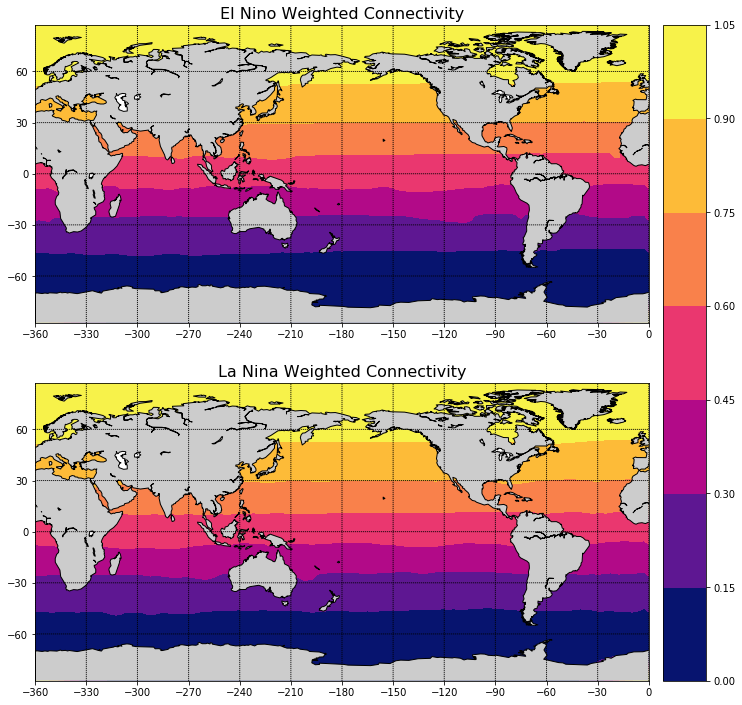

In [36]:
# find min/max connectivity between both plots
conmin = min(np.min(connectivity_elnino), np.min(connectivity_lanina))
conmax = max(np.max(connectivity_elnino), np.max(connectivity_lanina))
con_levels = np.linspace(conmin, conmax, 7)
# create normalized colorbar
norm = colors.Normalize(conmin, conmax)
# setup figure
fig, AX = plt.subplots(nrows=2, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(20)
fig.set_facecolor('white')
fig.tight_layout()

for idx in np.arange(2):
    # setup map projection
    m = bmp.Basemap(projection='cyl', resolution='c', lon_0=-180, lat_0=0,
                    llcrnrlon=-360, llcrnrlat=lats_corr[-1], urcrnrlon=0, urcrnrlat=lats_corr[0])
    m.drawcoastlines(ax=AX[idx])
    m.fillcontinents(ax=AX[idx])
    m.drawparallels(np.arange(-90, 90, 30), ax=AX[idx])
    m.drawmeridians(np.arange(0, 360, 30), ax=AX[idx])

    # add 360 degree lon point so map is continuous
    connectivity_elnino_cyc, lons_cyc = bmp.addcyclic(
        connectivity_elnino, lons)
    connectivity_lanina_cyc, lons_cyc = bmp.addcyclic(
        connectivity_lanina, lons)
    # Shift the grid so lons go from -180 to 180 instead of 0 to 360.
    connectivity_elnino_cyc, lons_cyc = bmp.shiftgrid(
        0, connectivity_elnino_cyc, lons_cyc, start=False)
    connectivity_lanina_cyc, lons_cyc = bmp.shiftgrid(
        0, connectivity_lanina_cyc, lons_cyc, start=False)

    # because lats, lons not the same length, create grid
    lons2d, lats2d = np.meshgrid(lons_cyc, lats_corr)
    x, y = m(lons2d, lats2d)

    # contour plots: top is el nino, bottom is la nina
    cs = m.contourf(x, y, connectivity_elnino_cyc, latlon=False,
                    ax=AX[0], cmap=cc.cm.linear_bmy_10_95_c71, norm=norm)
    AX[0].set_title("El Nino Weighted Connectivity", fontsize=16)

    cs = m.contourf(x, y, connectivity_lanina_cyc, latlon=False,
                    ax=AX[1], cmap=cc.cm.linear_bmy_10_95_c71, norm=norm)
    AX[1].set_title("La Nina Weighted Connectivity", fontsize=16)

# Colorbar
fig.subplots_adjust(right=.95, hspace=.2, top=.95)
# get location for top and bottom of colorbar
bottom = AX[1].get_position().ymin
top = AX[0].get_position().ymax
left = AX[1].get_position().xmax
cbar_ax = fig.add_axes([left+.01, bottom, .03, top-bottom])
cbar = fig.colorbar(cs, cax=cbar_ax, ticklocation='right')
#cbar.set_label("Fraction of Total Global Area Connected", fontsize=16)

# axis ticks
for ax in AX:
    ax.set_xticks(np.arange(-360, 1, 30))
    ax.set_yticks(np.arange(-90, 90, 30)[1:])
# savefig
fig.savefig('../Output/ElNinoLaNinaWeightedConnectivityTest2--TsonisFig1.jpg',)

What the hell.

# Network Analysis

Let's (re)-define some useful stuff first

In [22]:
# create list of lat/lon indicies
N = (len(lats)-2)*len(lons)
indicies = [(lat_idx, lon_idx) for lat_idx in np.arange(1, len(lats)-1)
            for lon_idx in np.arange(len(lons))]

Now the data

In [23]:
tsonCorRec = Dataset("../Output/tsonisCorrelationsRecreation.nc", "r")

In [24]:
adj_elnino = tsonCorRec.groups['elNino'].variables['adjacency']
adj_lanina = tsonCorRec.groups['laNina'].variables['adjacency']

Now we can begin analyzing the networks. First, let's look at the adjacency matricies.

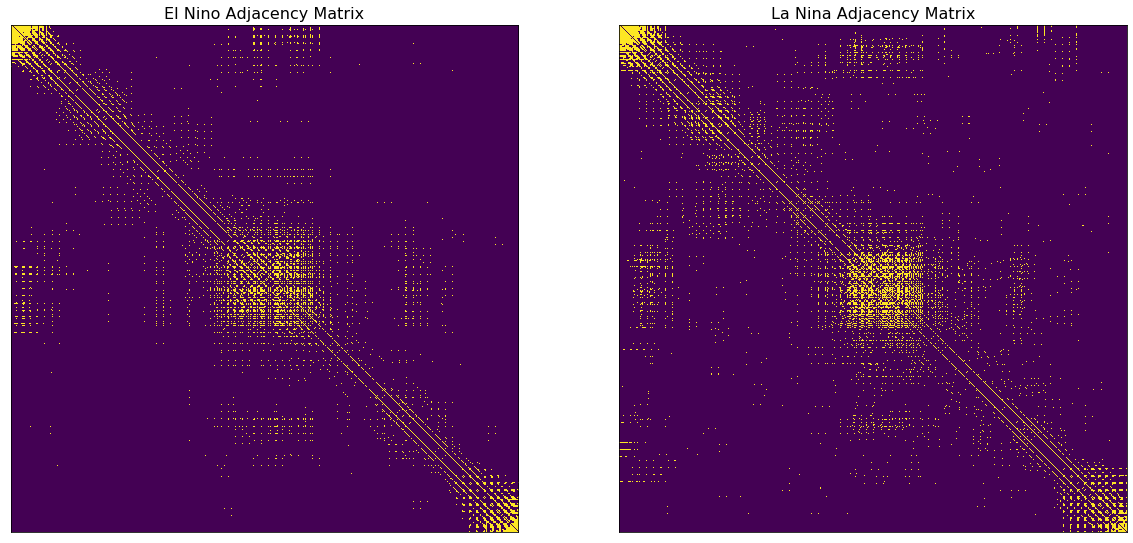

In [36]:
fig, AX = plt.subplots(1,2,sharey=True,sharex=True)
fig.set_figwidth(20)
fig.set_figheight(10)
fig.set_facecolor("white")

AX[0].imshow(adj_elnino)
AX[1].imshow(adj_lanina)

AX[0].set_title("El Nino Adjacency Matrix",fontsize=16)
AX[1].set_title("La Nina Adjacency Matrix",fontsize=16)
AX[0].set_xticks([])
AX[0].set_yticks([])

fig.savefig('../Output/tsonisAdjMatricies.jpg')

Dope. Now let's get more useful and calculate the degree distributions.

In [41]:
degs_elnino = np.sum(adj_elnino,0)
degs_lanina = np.sum(adj_lanina,0)

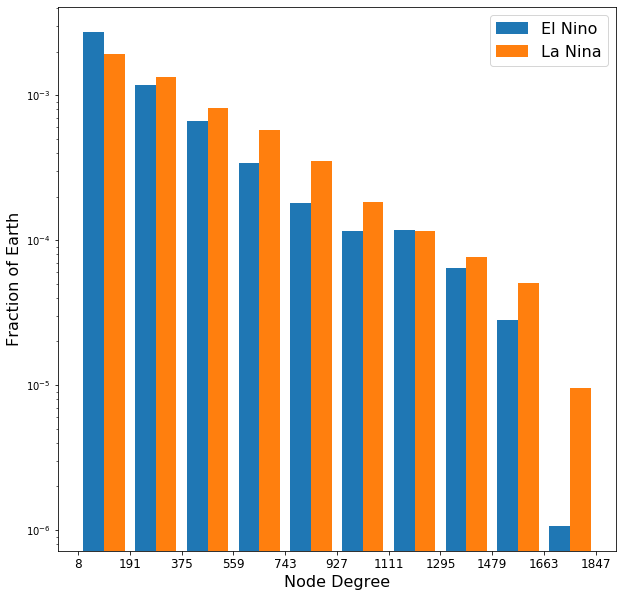

In [93]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_facecolor('white')

hist = ax.hist([degs_elnino, degs_lanina], bins=10, \
            label=["El Nino", "La Nina"],density=True, align='mid',log=True)
ax.set_xlabel('Node Degree',fontsize=16)
ax.set_ylabel('Fraction of Earth',fontsize=16)
ax.legend(fontsize=16)

#fix x axis
bins = hist[1]
ax.set_xticks(bins)
ax.set_xticklabels(bins.astype('int'), fontsize=12)

#fix y axis
ylabs = ax.get_yticklabels()



So ignoring the fact that that graph looks like shit, it more or less seems to agree with Tsonis's data. Now let's calculate the CDFs and see if they are any different.

In [106]:
# create list of all possible node degrees
max_deg = max(np.max(degs_elnino),np.max(degs_lanina))
xdata = np.arange(0,max_deg+1,1)

# find how many nodes have each degree or lower
cdf_elnino = np.zeros(len(xdata))
cdf_lanina = np.zeros(len(xdata))
for deg in xdata:
    cdf_elnino[deg] = np.sum(degs_elnino<=deg)
    cdf_lanina[deg] = np.sum(degs_lanina<=deg)
# and normalize to make it a cdf
cdf_elnino /= N
cdf_lanina /= N

Text(0, 0.5, 'Fraction of Nodes with Degree Less than $k$')

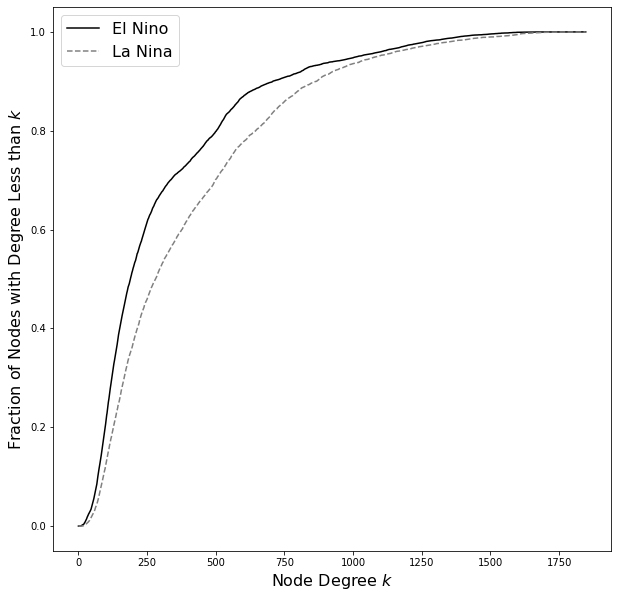

In [109]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_facecolor('white')

ax.plot(xdata,cdf_elnino, label='El Nino',ls='-',color='black')
ax.plot(xdata,cdf_lanina, label='La Nina',ls='--',color='gray')
ax.legend(fontsize=16)

ax.set_xlabel('Node Degree $k$',fontsize=16)
ax.set_ylabel('Fraction of Nodes with Degree Less than $k$',fontsize=16)

This graph also seems to be consistant with Tsonis's data. Now let's calculate the clustering coefficients and charecteristic path lengths!

In [3]:
# reimport adjacency matricies
recreation = Dataset('../Output/tsonisCorrelationsRecreation.nc')

In [96]:
elnino_adj = recreation.groups['elNino'].variables['adjacency'][:]
lanina_adj = recreation.groups['laNina'].variables['adjacency'][:]
adj_matricies = [elnino_adj, lanina_adj] # make the matricies easier to access later

In [103]:
N = elnino_adj.shape[0] # number of nodes

# create graphs
elnino_graph, lanina_graph = gt.Graph(), gt.Graph()
graphs = [elnino_graph, lanina_graph]
names = ['El Nino', 'La Nina']
clustering_coefs, char_paths = [], []
for gdx in np.arange(2):
    graphs[gdx].add_vertex(N)
    
    idx, idy = adj_matricies[gdx].nonzero() # get x and y indicies for location of edges
    indicies = np.dstack((idx,idy))
    indicies.resize((N,2)) # dstack returns array of shape (1,N,2), but we need shape (N,2)
    graphs[gdx].add_edge_list(indicies) # add edges to graph
    
    # calculate clustering coefficients and char path lengths
    clustering_coefs.append(gt.global_clustering(graphs[gdx]))
    dists = gt.shortest_distance(graphs[gdx]) # get geodesics as PropertyMap
    dists = dists.get_2d_array(np.arange(N)) # convert PropertyMap to matrix
    char_path_len = np.average(dists)/(N*(N-1)) 
    char_paths.append(char_path_len)

El Nino
----------


TypeError: unsupported format string passed to tuple.__format__

In [106]:
for idx in np.arange(2):
    print('{:s}'.format(names[idx]))
    print('-'*10)
    print('Clustering Coefficient: {:.3f}'.format(clustering_coefs[idx][0]))
    print('Char Path Length: {:.3f}\n'.format(char_paths[idx]))

El Nino
----------
Clustering Coefficient: 0.128
Char Path Length: 20.542

La Nina
----------
Clustering Coefficient: 0.097
Char Path Length: 20.542

